**LITT_WSI.jpynb** <br /> *Developed by Pouya M.* <br /> *Medical College of Wisconsin, 2025*

The purpose of this script is to analyze the SOX2 and Ki67 staining on the brain.

In [ ]:
# INTIALIZATION

## install dependencies
import matplotlib.pyplot as plt
import math
import numpy as np
import lavlab
import time
import pyvips
from lavlab.omero.images import get_large_recon, load_image_smart
from lavlab.omero.rois import get_rois, get_image_shapes_as_points
from tqdm import tqdm
from skimage.draw import polygon as skimage_polygon
from skimage.measure import block_reduce
from skimage.transform import resizels

from scipy.ndimage import distance_transform_edt
from littFunctions import DABLR
from omero.gateway import BlitzGateway, MapAnnotationWrapper
import getpass
from tqdm import tqdm

# connect to OMERO
username = input("Enter your OMERO username: ")
password = getpass.getpass("Enter your OMERO password: ")
conn = BlitzGateway(username, password, host="wss://wsi.lavlab.mcw.edu/omero-wss", port=443, secure=True)
conn.connect()
conn.SERVICE_OPTS.setOmeroGroup('-1')
conn.c.enableKeepAlive(30)

if conn.connect():
    conn.c.enableKeepAlive(30)
    print("Connection successful")
    user = conn.getUser()
    print("Current user:")
    print("   ID:", user.getId())
    print("   Username:", user.getName())
    print("   Full Name:", user.getFullName())
else:
    print("Connection failed")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
## create filled mask function
def create_filled_polygon_mask_skimage(vertices, height, width, mask_value=True, dtype=bool):
    if vertices is None or len(vertices) == 0:
        print("Warning: Empty list of vertices provided.")
        return np.zeros((height, width), dtype=dtype)

    # Initialize the mask
    mask = np.zeros((height, width), dtype=dtype)
    vertex_array = np.array(vertices)
    rows = vertex_array[:, 0] # .clip(0, height - 1) # y-coordinates are rows
    cols = vertex_array[:, 1] # .clip(0, width - 1)  # x-coordinates are columnss.
    rr, cc = skimage_polygon(rows, cols, shape=(height, width))
    mask[rr, cc] = mask_value
    return mask

def get_combined_masks(image, obj_color, ds=10, name="", show_progress=True):
    import math
    from tqdm import tqdm

    # Extract ROIs and shape info only once
    shapeinfo = get_image_shapes_as_points(image, point_downsample_factor=1, scale_factor=ds)
    yx_shape = image.getSizeY() / ds, image.getSizeX() / ds
    yx_shape_rounded = tuple(math.ceil(x) for x in yx_shape)

    indices = [i for i, (_, color, _) in enumerate(shapeinfo) if color == obj_color]
    range_func = tqdm if show_progress else lambda x, **kwargs: x

    def create_mask(i):
        poly_points = shapeinfo[i][2]
        mask = create_filled_polygon_mask_skimage(poly_points, *yx_shape_rounded)
        return mask.astype(bool)

    combmasks = [create_mask(i) for i in range_func(indices, desc=f"Extracting {name} ROIs")]
    return combmasks

def get_lr_in_vips(image_obj, ds=10):
    # get lr and convert it to vips_lr
    lr = get_large_recon(image_obj, ds=ds)
    lr_array = np.ascontiguousarray(lr, dtype=np.uint8)
    height, width, bands = lr_array.shape
    vips_lr = pyvips.Image.new_from_memory(
        lr_array.tobytes(),
        width,
        height,
        bands,
        'uchar'  # or the appropriate format for your dtype
    )
    return vips_lr

# PARAMETERS
# image_ids=[4113, 4291, 7088]
SOX2_image_ids=[4113]
CD31_image_ids=[4109] # ensure that these are in the same order as SOX2
ds=10
vessel_color = (255, 16, 0)
vessel_out_color = (255, 122, 0)
litt_color = (48, 255, 50)

# INITIALIZE DATA STRUCTURES
SOX2_vips_lr  = []    # the SOX2 large recon as a vips image
combmasks     = []    # the combined masks of vessels
littmasks     = []    # the litt mask for each patient
cell          = []    #
dabh          = []    #
hemh          = []    #
rat           = []    #
mask          = []    #

## get image
for i in range(len(SOX2_image_ids)):
    SOX2_image_id = SOX2_image_ids[i]
    SOX2_image = conn.getObject("Image", SOX2_image_id)
    SOX2_vips_lr.append(get_lr_in_vips(SOX2_image, ds=ds))
    
    combmasks.append(get_combined_masks(SOX2_image, vessel_color, ds, name = "Vessel In"))
    # combmasks.append(get_combined_masks(SOX2_image, vessel_out_color, ds, name = "Vessel Out"))
    littmasks.append(get_combined_masks(SOX2_image, litt_color, ds, name = "LITT"))
    d = DABLR(SOX2_vips_lr[-1], mask=None, down_factor = 10000)
    # c, d, h, r, m = DABLR(SOX2_vips_lr[-1], mask=None, down_factor = 10000)
    # cell.append(c)
    dabh.append(d)
    # hemh.append(h)
    # rat.append(r)
    # mask.append(m)

Extracting LITT ROIs: 100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


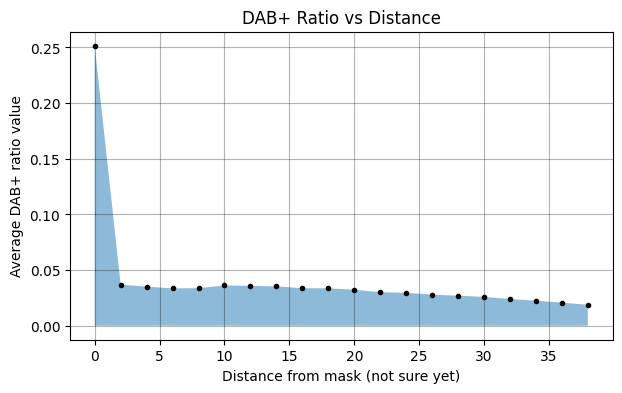

In [50]:
# V2 (Mulitple Patients)
# Outdated, don't use

from skimage.transform import resize
from scipy.ndimage import distance_transform_edt
import numpy as np
import matplotlib.pyplot as plt

averages = []
max_dist = 20 # pixels

for img_idx in range(len(combmasks)):                    # go through each patient in our index
    rat_arr = rat[img_idx]                               # extract the DAB+ ratio for this image
    for mask_idx in range(len(combmasks[img_idx])):      # go through each mask in the patient
        mask = combmasks[img_idx][mask_idx]              # define the mask
        
        # Resize the mask to match rat shape
        
        
        mask_resized = resize(mask, rat_arr.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
        
        # distance transfer calculation
        dist_um = distance_transform_edt(~mask_resized)
        bins = np.arange(0, max_dist + 1, 1)
        avg_by_distance = []
        for j in range(len(bins) - 1):
            in_bin = (dist_um >= bins[j]) & (dist_um < bins[j+1])
            if np.any(in_bin):
                avg = rat_arr[in_bin].mean()
            else:
                avg = np.nan
            avg_by_distance.append(avg)
            avg_by_distance = avg_by_distance.numpy()
        averages.append(avg_by_distance)

avg_of_averages = np.nanmean(np.array(averages), axis=0)
arr = avg_of_averages
um_axis = list(range(0, 2*len(arr), 2))  # adjust as needed for real physical scale

plt.figure(figsize=(7, 4))
plt.fill_between(um_axis, arr, alpha=0.5)
plt.grid(axis='both', color='k', alpha=0.3)
plt.scatter(um_axis, arr, marker='.', color='k')
plt.xlabel('Distance from mask (not sure yet)')  # or 'um' if calibrated
plt.ylabel('Average DAB+ ratio value')
plt.title('DAB+ Ratio vs Distance')
plt.show()

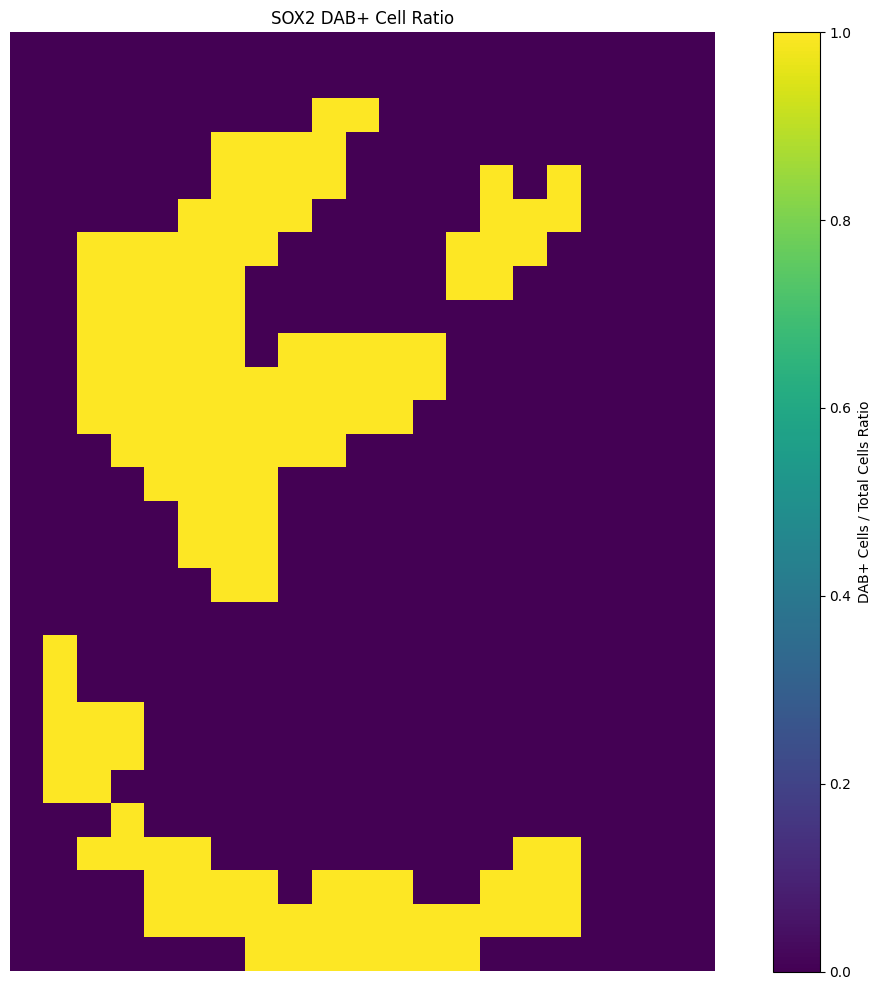

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dablr(array, mask=None, title="DAB Ratio"):
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(array, cmap='viridis', vmin=0, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('DAB+ Cells / Total Cells Ratio')
    
    ax.set_title(f"{title}")
    ax.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()  # Display the plot instead of saving it

# Given your data structure, you should be able to use this:
visualize_dablr(cell[0], title="SOX2 DAB+ Cell Ratio")

Starting analysis...
Length of combmasks: 2
Length of littmasks: 1
Length of rat: 1
Will process 1 images based on available data
Processed image 0, vessel mask 0
Processed image 0, vessel mask 1
Processed image 0, vessel mask 2
Processed image 0, vessel mask 3
Processed image 0, vessel mask 4
Processed image 0, vessel mask 5
Processed image 0, vessel mask 6
Processed image 0, vessel mask 7
Processed image 0, vessel mask 8
Processed image 0, vessel mask 9
Processed image 0, vessel mask 10
Processed image 0, vessel mask 11
Processed image 0, vessel mask 12
Processed image 0, vessel mask 13
Processed image 0, vessel mask 14
Processed image 0, vessel mask 15
Processed image 0, vessel mask 16
Processed image 0, vessel mask 17
Processed image 0, vessel mask 18
Processed image 0, vessel mask 19
Processed image 0, vessel mask 20
Processed image 0, vessel mask 21
Processed image 0, vessel mask 22
Processed image 0, vessel mask 23
Processed image 0, vessel mask 24
Processed image 0, vessel mask

/tmp/ipykernel_5020/2425526402.py:103: RuntimeWarning: Mean of empty slice
  final_avg_grid = np.nanmean(results_stack_3d, axis=0)


Generating 2D heatmap...


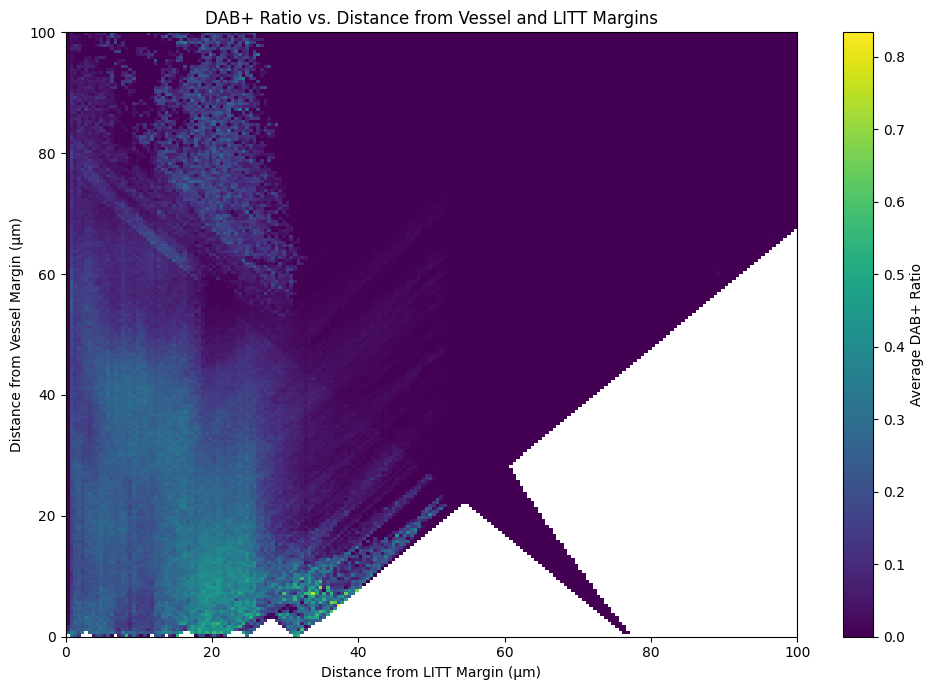

In [40]:
# V3 (Multiple Patients + Distance from LITT + Distance from Vessel)

from skimage.transform import resize
from scipy.ndimage import distance_transform_edt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Configuration ---
max_dist_vessel = 200  # Max distance from vessel to analyze (pixels)
max_dist_litt = 200    # Max distance from LITT to analyze (pixels)
pixel_to_um_scale = 0.5 # Example: 0.5 micrometers per pixel. Adjust to your data.

# This list will store a 2D result grid for each individual vessel mask
all_results_2d = []

# --- Main Processing Loop ---
print("Starting analysis...")

# First, check input data lengths to prevent IndexError
print(f"Length of combmasks: {len(combmasks)}")
print(f"Length of littmasks: {len(littmasks)}")
print(f"Length of rat: {len(rat)}")

# Determine the number of images to process (minimum length of all lists)
num_images = min(len(combmasks), len(littmasks), len(rat))
print(f"Will process {num_images} images based on available data")

# Define distance axis arrays for visualization
dist_vessel_axis = np.arange(0, max_dist_vessel) * pixel_to_um_scale
dist_litt_axis = np.arange(0, max_dist_litt) * pixel_to_um_scale

for img_idx in range(num_images):
    rat_arr = rat[img_idx]
    
    # 1. Create a unified LITT mask for the current image
    if not littmasks[img_idx]:
        print(f"Warning: Image {img_idx} has no LITT masks. Skipping this image.")
        continue
        
    # Initialize a base mask with the correct shape
    unified_litt_mask = np.zeros(rat_arr.shape, dtype=bool)
    for l_mask in littmasks[img_idx]:
        try:
            l_mask_resized = resize(l_mask, rat_arr.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
            unified_litt_mask |= l_mask_resized
        except Exception as e:
            print(f"Error resizing LITT mask for image {img_idx}: {str(e)}")
            continue

    # 2. Calculate distance from the unified LITT margin for the whole image
    dist_litt = distance_transform_edt(~unified_litt_mask)

    # 3. Iterate through each vessel mask in the current image
    if not combmasks[img_idx]:
        print(f"Warning: Image {img_idx} has no vessel masks. Skipping this image.")
        continue
        
    for mask_idx, vessel_mask in enumerate(combmasks[img_idx]):
        try:
            # Resize vessel mask to match rat's shape
            vessel_mask_resized = resize(vessel_mask, rat_arr.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
            
            # 4. Calculate distance from the current vessel margin
            dist_vessel = distance_transform_edt(~vessel_mask_resized)
            
            # 5. Perform 2D binning for this specific mask
            avg_grid_for_this_mask = np.full((max_dist_vessel, max_dist_litt), np.nan)
            
            for i in range(max_dist_vessel):      # Iterate through vessel distance bins
                for j in range(max_dist_litt):    # Iterate through LITT distance bins
                    
                    # Find all pixels that are in the 2D bin [i, j]
                    in_bin = (
                        (dist_vessel >= i) & (dist_vessel < i + 1) &
                        (dist_litt >= j) & (dist_litt < j + 1)
                    )
                    
                    # If any pixels are in this bin, calculate their average rat value
                    if np.any(in_bin):
                        avg = rat_arr[in_bin].mean()
                        avg_grid_for_this_mask[i, j] = avg
            
            # Add the 2D grid for this mask to our collection
            all_results_2d.append(avg_grid_for_this_mask)
            print(f"Processed image {img_idx}, vessel mask {mask_idx}")
            
        except Exception as e:
            print(f"Error processing vessel mask {mask_idx} for image {img_idx}: {str(e)}")
            continue

print(f"Analysis complete. Processed {len(all_results_2d)} individual vessel masks.")

# --- Averaging and Finalizing ---
# Convert the list of 2D arrays into a single 3D array
if not all_results_2d:
    print("No data was processed. Exiting.")
else:
    results_stack_3d = np.array(all_results_2d)

    # Calculate the mean across all masks, ignoring NaNs
    # axis=0 averages along the 'mask' dimension
    final_avg_grid = np.nanmean(results_stack_3d, axis=0)

    # --- 2D Heatmap Visualization ---
    print("Generating 2D heatmap...")

    plt.figure(figsize=(10, 7))
    extent = [
        dist_litt_axis[0], dist_litt_axis[-1] + pixel_to_um_scale,   # x-axis: LITT (μm)
        dist_vessel_axis[0], dist_vessel_axis[-1] + pixel_to_um_scale  # y-axis: Vessel (μm)
    ]
    im = plt.imshow(
        final_avg_grid,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='viridis'
    )
    plt.colorbar(im, label='Average DAB+ Ratio')
    plt.title('DAB+ Ratio vs. Distance from Vessel and LITT Margins')
    plt.xlabel('Distance from LITT Margin (μm)')
    plt.ylabel('Distance from Vessel Margin (μm)')
    plt.tight_layout()
    # plt.savefig('vessel_litt_analysis_heatmap.png', dpi=300)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def vips2numpy(img):
    """Convert pyvips.Image to numpy array (H, W[, C])."""
    img = img.copy_memory()
    width = img.width
    height = img.height
    bands = img.bands
    arr = np.frombuffer(img.write_to_memory(), dtype=np.uint8)
    arr = arr.reshape(height, width, bands)
    if arr.shape[2] == 1:
        arr = arr[:, :, 0]
    return arr

# Combine all combmasks as before
all_masks = []
for image_mask_list in combmasks:
    for mask in image_mask_list:
        all_masks.append(mask.astype(bool))

# Use the shape of the first vips_lr image as the target shape
vips_img = vips2numpy(vips_lr[0])  # Use the first vips_lr image; change index as needed
target_shape = vips_img.shape[:2]

# Resize all masks to match the image shape
processed_masks = []
for mask in all_masks:
    if mask.shape != target_shape:
        mask = resize(mask, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)
    processed_masks.append(mask)

# Combine all masks into one (logical OR)
finalmask = np.zeros(target_shape, dtype=bool)
for mask in processed_masks:
    finalmask |= mask

# Prepare overlay visualization
if vips_img.ndim == 2:
    base = np.stack([vips_img] * 3, axis=-1)
else:
    base = vips_img.copy()
if base.max() > 255:
    base = base.astype(np.float32)
    base = 255 * (base - base.min()) / (base.max() - base.min())
base = base.astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(base, alpha=1.0)
plt.imshow(finalmask.astype(np.float32), cmap="Blues", alpha=0.4)
plt.title("Combined Vessel Mask Overlay on VIPS Image")
plt.axis("off")
plt.show()

In [14]:
# V1 (Single Patient)
# Outdated, don't use

from skimage.transform import resize
from scipy.ndimage import distance_transform_edt
import cv2

# resize + find center of each mask 
averages = []
max_dist = 20 # pixels
for i in range(len(combmasks)):
    combmasks[i] = resize(combmasks[i], rat.shape, order=0, preserve_range=True, anti_aliasing=False)
    combmask = combmasks[i]
    dist_um = distance_transform_edt(~combmask)
    # max_dist = dist_um.max()
    bins = np.arange(0, max_dist + 1, 1)
    avg_by_distance = []
    for j in range(len(bins) - 1):
        in_bin = (dist_um >= bins[j]) & (dist_um < bins[j+1])
        if np.any(in_bin):
            avg = rat[in_bin].mean()
        else:
            avg = np.nan
        avg_by_distance.append(avg)
    averages.append(avg_by_distance)

avg_of_averages = np.nanmean(np.array(averages), axis=0) 
arr = avg_of_averages
um_axis = list(range(0, 2*len(arr), 2))
n_bins = len(arr)

plt.figure(figsize=(7,4))
plt.fill_between(um_axis, arr, alpha=0.5) 
plt.grid(axis='both', color='k', alpha=0.3)
plt.scatter(um_axis, arr, marker='x', color='k')
plt.xlabel('Distance from mask (um)')
plt.ylabel('Average DAB+ ratio value')
plt.title('DAB+ Ratio vs Distance')
plt.show()


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# VALIS alignment (retired)

import os
import tifffile
import numpy as np
from valis import preprocessing
from valis.registration import Valis

# Save SOX2 and CD31 images as TIFFs (downsampled)
def save_before_img(img_obj, title, ds=10):
    os.makedirs('before-valis', exist_ok=True)
    lr = get_large_recon(img_obj, ds=ds)
    output_path = os.path.join('before-valis', f'{title}.tiff')
    tifffile.imwrite(output_path, lr)
    return output_path

class FullMaskProcesser(preprocessing.OD):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def create_mask(self, *args, **kwargs):
        img_mask = np.full(self.image.shape[0:2], 255, dtype=np.uint8)
        return img_mask

def save_mask_for_valis(img_path):
    """
    Given a TIFF path, create a full mask and save to the VALIS mask location.
    """
    img = tifffile.imread(img_path)
    src_f = img_path
    level = 0
    series = 0
    mask_processor = FullMaskProcesser(img, src_f, level, series)
    # This will set .mask on the processor (used by VALIS)
    mask = mask_processor.create_mask()
    # VALIS expects masks in a 'masks' subdirectory with matching filenames
    mask_dir = os.path.join(os.path.dirname(img_path), "masks")
    os.makedirs(mask_dir, exist_ok=True)
    mask_path = os.path.join(mask_dir, os.path.basename(img_path))
    tifffile.imwrite(mask_path, mask)
    return mask_path

# Example usage: save images and masks before registration
sox2_path = save_before_img(SOX2_image, title='SOX2', ds=ds)
cd31_path = save_before_img(CD31_image, title='CD31', ds=ds)

# Ensure lexicographical order for reference
before_dir = "before-valis"
files = os.listdir(before_dir)
cd31_file = [f for f in files if "CD31" in f][0]
sox2_file = [f for f in files if "SOX2" in f][0]
cd31_new = os.path.join(before_dir, '1_CD31_before.tiff')
sox2_new = os.path.join(before_dir, '2_SOX2_before.tiff')
os.rename(os.path.join(before_dir, cd31_file), cd31_new)
os.rename(os.path.join(before_dir, sox2_file), sox2_new)

# Create masks for each image (VALIS will auto-find these)
save_mask_for_valis(cd31_new)
save_mask_for_valis(sox2_new)

# Run registration
os.makedirs('after-valis', exist_ok=True)
registrar = Valis('before-valis', 'after-valis')
rigid_registrar, non_rigid_registrar, error_df = registrar.register()

print("Registration complete!")